# Height distribution analysis_AFM in histo bar__Plus Area under each peak

['C:\\Users\\begzaasa\\OneDrive - Victoria University of Wellington - STAFF\\Documents\\Desktop\\new2\\S3_5min-1.xyz']


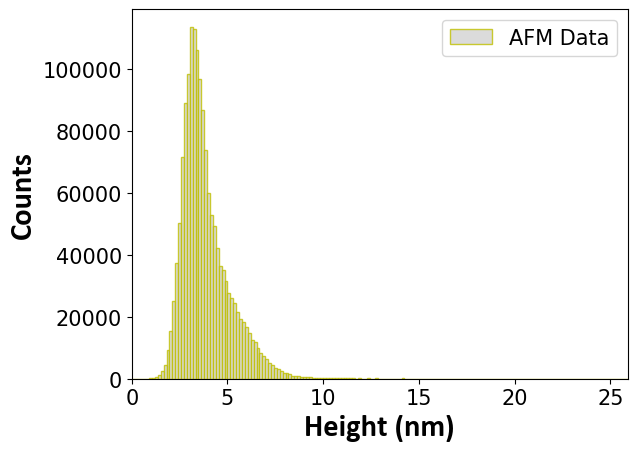

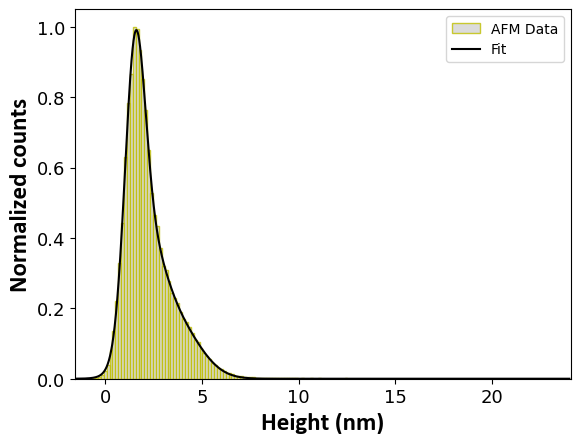

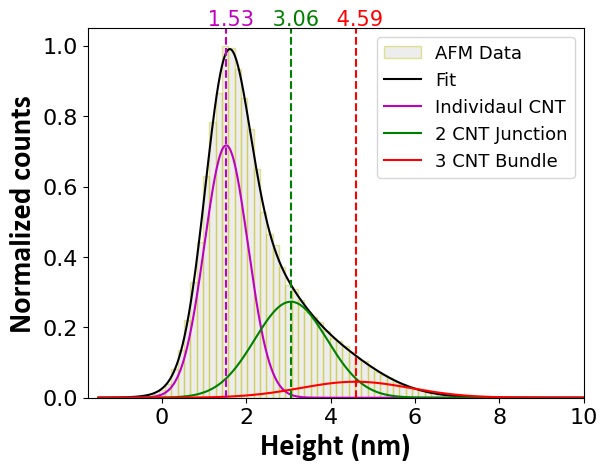

Height of Gaussian/Peak-1: 1.5286, Normalized Peak-1 Value: 0.6926
Height of Gaussian/Peak-2: 3.0619, Normalized Peak-2 Value: 0.2635
Height of Gaussian/Peak-3: 4.5935, Normalized Peak-3 Value: 0.0439


In [3]:
import os
import re
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.signal
import cv2
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Path to the data
path = 'C:\\Users\\VUW\\Documents\\Desktop\\NewFolder'

files = glob.glob(path + '/*.xyz')
print(files)  # Check to make the file is there

# Function to get device name from directory path
def getdevicename(file):
    filename = file.split('\\')
    devicetemp = (filename[-1].split('.'))[0]  # Grab the last part and remove the extension
    device = devicetemp
    return device

# Initialize dictionary to hold z data for each device
z_dictionary = {}
max_dictionary = {}

# Iterate through files to read data
for xyz in files:
    device = getdevicename(xyz)
    df = pd.read_table(xyz, engine='python', names=['x', 'y', 'z'])
    df.columns = ["x", "y", "z"]

    # Create variable for z data
    z_data = df.z
    z_dictionary[device] = z_data
    maxZ = max(z_data)
    max_dictionary[device] = maxZ

# Function to fit 3 Gaussians to each histogram
def tri_norm(x, *args):
    m1, m2, m3, s1, s2, s3, k1, k2, k3 = args
    ret = k1 * np.exp(-((x - m1) / s1) ** 2)
    ret += k2 * np.exp(-((x - m2) / s2) ** 2)
    ret += k3 * np.exp(-((x - m3) / s3) ** 2)
    return ret

# Initialize table
table = []

# Iterate through the files to generate plots
for xyz in files:
    device = getdevicename(xyz)

    # Define the new center (in nm) before using it. Surface roughness obtained by Gwyddion software for the image, which should be obtained for each image separately!
    new_center_nm = 1.72

    # Create histogram data
    bin_size = 15e-11
    bin_edges = np.arange(0, max_dictionary[device], bin_size)
    bin_centers = bin_edges[2:len(bin_edges)] - bin_size / 2
    bin_centers_nm = bin_centers / 1e-9
    number_bins = len(bin_centers)

    # Plot the histogram directly
    plt.hist(z_dictionary[device] / 1e-9, bins=number_bins, color='lightgray', edgecolor='y', alpha=0.8)  # Histogram bar plot

    # Get counts after plotting to normalize for further processing
    counts, _ = np.histogram(z_dictionary[device], bins=number_bins)
    max_count = max(counts)

    # Set font size for tick labels
    plt.xticks(fontsize=15)  # Set font size for x-axis tick labels
    plt.yticks(fontsize=15)  # Set font size for y-axis tick labels

    # Set histogram labels
    # plt.title(f'Height distribution of film: {device}, (Ave. surface roughness= {new_center_nm} nm)', pad=20)
    plt.xlabel('Height (nm)', fontweight='bold', fontname='Calibri', fontsize=22)
    plt.ylabel('Counts', fontweight='bold', fontname='Calibri', fontsize=22)
    plt.legend(['AFM Data'], fontsize=15)
    plt.autoscale(enable=True, axis='x', tight=True)
    save_path = os.path.join(path, f'AFM-Data_{device}.png')

    # Save the figure with a higher DPI for better quality
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 'bbox_inches' ensures the layout fits well
    plt.show()

    # Fitting peaks
    x = bin_centers_nm
    y = counts / max_count  # Normalizes counts
    shift = new_center_nm - 0
    x_shifted = x - shift

    # --- SAVE SHIFTED HISTOGRAM AND RELOAD IT (apply everything on this file) ---
    shifted_df = pd.DataFrame({"x_shifted_nm": x_shifted, "y_normalized": y})
    shifted_csv_path = os.path.join(path, f"shifted_hist_{device}.csv")
    shifted_df.to_csv(shifted_csv_path, index=False)

    # Re-call (reload) the shifted data and proceed using it
    shifted_loaded = pd.read_csv(shifted_csv_path)
    x_shifted = shifted_loaded["x_shifted_nm"].values
    y = shifted_loaded["y_normalized"].values
    # ---------------------------------------------------------------------------

    # First guess and first fit (Initial guess)
    # m1, m2, m3, s1, s2, s3, k1, k2, k3 = args, m- center, s- width, k- counts/amplitude
    # >>> EDIT THESE THREE NUMBERS TO MOVE PEAK CENTERS (ON SHIFTED AXIS) <<<
    params = [1.55, 3.3, 4.8, 4, 1, 6, 1.6, 1, 0.04]  # m1=1.55, m2=3.3, m3=4.8; S & K unchanged

    fitted_params, cov = curve_fit(tri_norm, x_shifted, y, p0=params, bounds=(0, 10))

    # Plotting fitted data with label
    bar_container = plt.bar(x_shifted, y, width=np.diff(bin_edges)[:-1] / 1e-9, color='lightgray', edgecolor='y', alpha=0.8, label='AFM Data')

    # Plot the fitted function with label
    xx = np.linspace(np.min(x_shifted), np.max(x_shifted), 10000)
    fit_line, = plt.plot(xx, tri_norm(xx, *fitted_params), color='black', label='Fit')  # Use the line as a plot handle

    # Set plot title and labels
    #plt.title(f'Height distribution of film: {device}, (Ave. surface roughness= {new_center_nm} nm)', pad=20)
    plt.xlabel('Height (nm)', fontweight='bold', fontname='Calibri', fontsize=18)  # Set font size for x-axis
    plt.ylabel('Normalized counts', fontweight='bold', fontname='Calibri', fontsize=18)  # Set font size for y-axis

    # Set font size for tick labels
    plt.xticks(fontsize=13)  # Set font size for x-axis tick labels
    plt.yticks(fontsize=13)  # Set font size for y-axis tick labels

    # Set the legend explicitly using the handles used in the plots
    plt.legend([bar_container, fit_line], ['AFM Data', 'Fit'], fontsize=10)

    plt.autoscale(enable=True, axis='x', tight=True)

    # Save the first fitted plot as a PNG file
    save_path = os.path.join(path, f'AFM&FIT_{device}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 'bbox_inches' ensures the layout fits well
    plt.show()

    # Create plot with AFM data, fit data, and 3 Gaussians
    bar_container = plt.bar(x_shifted, y, width=np.diff(bin_edges)[:-1] / 1e-9, color='lightgray', edgecolor='y', alpha=0.4, label='AFM Data')
    fit_line, = plt.plot(xx, tri_norm(xx, *fitted_params), color='black', label='Fit')

    # 3 Gaussians
    # Define Gaussian parameters based on fitted results 
    # m1, m2, m3, s1, s2, s3, k1, k2, k3 = args; m = center, s = width, k = amplitude
    m1 = fitted_params[0] 
    m2 = fitted_params[1] +0.91
    m3 = fitted_params[2] +1.11

    s1 = fitted_params[3] 
    s2 = fitted_params[4]
    s3 = fitted_params[5] 

    k1 = fitted_params[6]
    k2 = fitted_params[7] 
    k3 = fitted_params[8]-0.12

    # Calculate shifted Gaussians for plotting
    gaussian_1 = k1 * np.exp(-((xx - m1) / s1) ** 2)
    gaussian_2 = k2 * np.exp(-((xx - m2) / s2) ** 2)
    gaussian_3 = k3 * np.exp(-((xx - m3) / s3) ** 2)

    gaussian_line_1, = plt.plot(xx, gaussian_1, color='m', label='Gaussian 1')
    gaussian_line_2, = plt.plot(xx, gaussian_2, color='g', label='Gaussian 2')
    gaussian_line_3, = plt.plot(xx, gaussian_3, color='r', label='Gaussian 3')

    # Add vertical lines for the center of each Gaussian with labels
    plt.axvline(x=m1, color='m', linestyle='dashed')
    plt.text(m1 - 0.6, 1.075, " %.2f" % m1, color='m', rotation=0, verticalalignment='center', fontsize=15)
    plt.axvline(x=m2, color='g', linestyle='dashed')
    plt.text(m2 - 0.6, 1.075, " %.2f" % m2, color='g', rotation=0, verticalalignment='center', fontsize=15)
    plt.axvline(x=m3, color='r', linestyle='dashed')
    plt.text(m3 - 0.6, 1.075, " %.2f" % m3, color='r', rotation=0, verticalalignment='center', fontsize=15)

    # Set font size for tick labels
    plt.xticks(fontsize=16)  # Set font size for x-axis tick labels
    plt.yticks(fontsize=16)  # Set font size for y-axis tick labels

    # Set the title
    # plt.title(f'Height distribution of film: {device}, ( Ave. surface roughness= {new_center_nm} nm)', pad=20)
    plt.xlabel('Height (nm)', fontweight='bold', fontname='Calibri', fontsize=22)
    plt.ylabel('Normalized counts', fontweight='bold', fontname='Calibri', fontsize=22)

    # Set the legend in the desired order
    plt.legend([bar_container, fit_line, gaussian_line_1, gaussian_line_2, gaussian_line_3],
               ['AFM Data', 'Fit', 'Individaul CNT', '2 CNT Junction', '3 CNT Bundle'], fontsize=13)

    # plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlim(-1.75, 10)

    # Save the plot as a PNG file in the same directory as the input files
    save_path = os.path.join(path, f'H_{device}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 'bbox_inches' ensures the layout fits well
    plt.show()

    # Function to calculate the area under each Gaussian (kept for reference; not used below)
    def calculate_gaussian_area(k, s):
        return k * s * np.sqrt(2 * np.pi)

    # ===== CHANGED: Use normalized (relative) peak values instead of areas =====
    total_amplitude = k1 + k2 + k3
    norm1 = k1 / total_amplitude
    norm2 = k2 / total_amplitude
    norm3 = k3 / total_amplitude

    # Calculate the height (center) of each Gaussian (in shifted nm)
    height1 = m1
    height2 = m2
    height3 = m3

    # Print the heights along with normalized peak values (still in shifted nm)
    print(f"Height of Gaussian/Peak-1: {height1:.4f}, Normalized Peak-1 Value: {norm1:.4f}")
    print(f"Height of Gaussian/Peak-2: {height2:.4f}, Normalized Peak-2 Value: {norm2:.4f}")
    print(f"Height of Gaussian/Peak-3: {height3:.4f}, Normalized Peak-3 Value: {norm3:.4f}")

    # Save the normalized peak values and heights to a CSV for further analysis
    areas = {
        "Gaussian": ["Gaussian 1", "Gaussian 2", "Gaussian 3"],
        "Center_shifted_nm": [height1, height2, height3],
        "Normalized Peak Value": [norm1, norm2, norm3]
    }
    areas_df = pd.DataFrame(areas)
    areas_save_path = os.path.join(path, f'Gaussian_detail_{device}.csv')
    areas_df.to_csv(areas_save_path, index=False)

    # Display the image using OpenCV
    img = cv2.imread(save_path)  # Read the saved image
    cv2.imshow(f'Height distribution of film: {device}', img)  # Show the image
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()  # Close all OpenCV windows


# AFM Height-Histogram → 3-Gaussian Fit (CNT thin films)

# What this script expects

•	Input: AFM images that have already been levelled/processed in Gwyddion (or any equivalent tool) and exported as .xyz file.

    ## Surface roughness anchor: 'new_center_nm' is the average surface roughness obtained from Gwyddion for each image.

# What the script does (step-by-step)

•	Loads all .xyz files in the target directory, extracts the height channel z.

•	Builds a height histogram in nm and normalizes the counts.

•	Recenters the x-axis by subtracting new_center_nm (nm) so the histogram is expressed on a shifted axis relative to the roughness.

        ## The shifted histogram (x_shifted_nm, y_normalized) is saved to CSV and then reloaded; all fitting/plotting uses this shifted data (so the initial guesses for M, S and K are always on the shifted axis).

•	Fits the sum of three Gaussians to the shifted histogram using scipy.optimize.curve_fit with the model
    
    tri_norm(x) = Σ k_i * exp(-((x - m_i)/s_i)^2) where:

        ## m_i = peak center (nm on the shifted axis)

        ## s_i = peak width (nm)

        ## k_i = peak amplitude (relative height)

 •	Plots the histogram, the global fit, and the three individual Gaussian components, and draws dashed lines at the fitted centers.

•	Exports a small CSV with the fitted centers (shifted nm) and normalized peak amplitudes.


# How to set initial guesses (on the shifted axis)

•	Intial guesses are provided in the array:

        params = [m1, m2, m3,  s1, s2, s3,  k1, k2, k3]
        params = [1.55, 3.30, 4.80,  4, 1, 6,  1.6, 1, 0.04]    # An example of intial guesses for M, S and K.

•	Interpretation strategy we use here:

•	The first peak corresponds to the individual CNT diameter band seen in your shifted histogram; we seed m1 near that value (e.g., ~1.5–1.7 nm). We do not force it—this is just the starting point for the optimizer.

•	For peaks 2 and 3, we seed centers by data-guided multiples of the first peak (e.g., ~2× and ~3× the first peak’s center) to represent junctions/bundles. In the example above: m2≈3.06 nm, m3≈4.59 nm.

•	Widths (S) & Amplitudes (K):
            We keep the Peak-1 width (s1) and amplitude (k1) as returned directly from the shifted data fit (no manual adjustment), with s1 only refitted if required to ensure proper alignment with the main Gaussian band.
    
    For Peaks-2 and 3, we:
            (i) keep their widths (s2, s3) as fitted by the optimizer,
            (ii) For K3: tweak amplitudes to sit main Gaussian band fit curve—without changing widths.

        # Post-fit decomposition used for visualization/reporting
        m1 = fitted_params[0]
        m2 = fitted_params[1] + 0.91   # Fit to ~2× of Peak-1
        m3 = fitted_params[2] + 1.11   # Fit to ~3× of Peak-1

        s1 = fitted_params[3]
        s2 = fitted_params[4]          # widths kept from optimizer
        s3 = fitted_params[5]

        k1 = fitted_params[6]
        k2 = fitted_params[7]          # amplitudes mostly preserved
        k3 = fitted_params[8] - 0.12   # minor amplitude tweak for Peak-3

# Outputs

•	AFM-Data_<device>.png: raw histogram (counts).

•	AFM&FIT_<device>.png: shifted, normalized histogram + total fit.

•	H_<device>.png: shifted histogram + total fit + individual Gaussians with labeled centers.

•	shifted_hist_<device>.csv: the shifted histogram used for fitting.

•	Gaussian_detail_<device>.csv: fitted centers (shifted nm) and normalized peak values.


# Manual refinement:
•	Run the code with the surface roughness (new_center_nm) manually entered, then update m2 and m3 (as shown above) and k3 only if necessary.
        If a component (e.g., k3) sits visibly above the overall fitted envelope, adjust k2 and k3 only, keeping s2, s3 fixed.

